# XDMoD Data Analytics Framework — Machine Learning Example
v1.0.1

© 2023 University at Buffalo Center for Computational Research

See the [xdmod-notebooks](https://github.com/ubccr/xdmod-notebooks) repository for licensing information.

## Introduction
The XDMoD Data Analytics Framework provides API access to the data in XDMoD via the [`xdmod_data` Python module](https://pypi.org/project/xdmod-data). This notebook provides an example showing how to use the `get_raw_data()` method to obtain and process raw job performance data, which is contained in the `SUPREMM` realm in XDMoD, and use the data to train a machine learning model.

## Install/upgrade the required modules
Run the code below to install/upgrade the modules needed to run this notebook.

In [ ]:
import sys
! {sys.executable} -m pip install --upgrade 'xdmod-data>=1.0.0,<2.0.0' python-dotenv tabulate

If running that code caused a new version of Plotly to be installed/upgraded, you may need to refresh your browser window for plots to appear correctly.

## Configure notebook formatting

### Exceptions
Run the code below to simplify how Python exceptions are displayed in this notebook.

In [ ]:
import sys
def exception_handler(exception_type, exception, traceback):
    print("%s: %s" % (exception_type.__name__, exception), file=sys.stderr)
get_ipython()._showtraceback = exception_handler

### Tables
Run the code below to set up for displaying Pandas DataFrames as Markdown tables in this notebook.

In [ ]:
from IPython.display import display, Markdown
def display_df_md_table(df):
    return display(Markdown(df.replace('\n', '<br/>', regex=True).to_markdown()))

### Plots
Run the code below to set up the external Plotly library to make plots using a custom XDMoD theme.

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import xdmod_data.themes
pio.templates.default = "timeseries"

## Create an environment file
The `xdmod-data.env` file will store your XDMoD API token.

Run the code below to create the file in your home directory (if it does not already exist) and allow only you to read and write to it.

In [ ]:
from pathlib import Path
from os.path import expanduser
xdmod_data_env_path = Path(expanduser('~/xdmod-data.env'))
try:
    with open(xdmod_data_env_path):
        pass
except FileNotFoundError:
    with open(xdmod_data_env_path, 'w') as xdmod_data_env_file:
        xdmod_data_env_file.write('XDMOD_API_TOKEN=')
    xdmod_data_env_path.chmod(0o600)

## Obtain an API token
Follow [these instructions](https://github.com/ubccr/xdmod-data#api-token-access) to obtain an API token.

## Store your API token in the environment file
Open the `xdmod-data.env` file and paste your token after `XDMOD_API_TOKEN=`.

Save the file.

## Load your XDMoD API token into the environment
Run the code below to load the contents of the `xdmod-data.env` file into the environment. It will print `True` if it successfully loaded the file.

In [ ]:
from dotenv import load_dotenv
load_dotenv(xdmod_data_env_path, override=True)

## Initialize the XDMoD Data Warehouse
Run the code below to prepare for getting data from the XDMoD data warehouse at the given URL.

In [ ]:
from xdmod_data.warehouse import DataWarehouse
dw = DataWarehouse('https://xdmod.access-ci.org')

## Get the raw data

Use the `get_raw_data()` method to request raw data from XDMoD and load them into a Pandas DataFrame. For example, get two days' worth of job performance data for the ACCESS-allocated Stampede2 and Bridges-2 resources. Each of the parameters of the `get_raw_data()` method will be explained later in this notebook. Use `with` to create a runtime context; this is also explained later in this notebook.

In [ ]:
with dw:
    data = dw.get_raw_data(
        duration=('2023-05-01', '2023-05-02'),
        realm='SUPREMM',
        fields=(
            'CPU User',
            'Nodes',
            'Wall Time',
            'Wait Time',
            'Requested Wall Time',
            'Total memory used',
            'Mount point "home" data written',
            'Mount point "scratch" data written',
        ),
        filters={
            'Resource': [
                'STAMPEDE2 TACC',
                'Bridges 2 RM',
            ],
        },
        show_progress=True,
    )

## Inspect the data

In [ ]:
display(data)

## Prepare data for training

Looking at the summary table, there are some records that have `<NA>` values. This is not unusal and is typically because the data were not collected (insufficient data points, errors in the data collection, etc.).

To prepare for training, filter out the jobs that have no CPU user or filesystem data:

In [ ]:
data = data[data['CPU User'].notna()]
data = data[data['Mount point "scratch" data written'].notna()]
display(data)

Set the data type of the columns to 64-bit floating-point:

In [ ]:
import numpy as np
data = data.astype(np.float64)

Use [scikit-learn](https://scikit-learn.org/) to split the jobs into a training set and test set:

In [ ]:
from sklearn.model_selection import train_test_split
X = data[[
    'Nodes',
    'Wall Time',
    'Wait Time',
    'Requested Wall Time',
    'Total memory used',
    'Mount point "home" data written',
    'Mount point "scratch" data written',
]]
y = data['CPU User']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)
display(Markdown("Size of the test subset is **" + str(len(X_test)) + "**."))
display(Markdown("Size of the training subset is **" + str(len(X_train)) + "**."))

## Generate a Random Forest Regression model

Using the tools from `scikit-learn`, build a Random Forest Regression model.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

RandomForestRegModel = RandomForestRegressor()
RandomForestRegModel.fit(X_train, y_train)

### Compute feature importances

In [ ]:
import numpy as np
importances = RandomForestRegModel.feature_importances_
std = np.std(
    [tree.feature_importances_ for tree in RandomForestRegModel.estimators_],
    axis=0,
)
indices = np.argsort(importances)[::-1]
# Calculate feature importances
importances = RandomForestRegModel.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]
md = "|Feature Name | Importance |\n|-------|:----|\n"
for i in indices:
    md += "|{}|{:1.4}|\n".format(names[i], importances[i])
display(Markdown(md))

### Predict regression targets

In [ ]:
X_train_predict = RandomForestRegModel.predict(X_train)
X_test_predict = RandomForestRegModel.predict(X_test)

### Compute R<sup>2</sup> values

In [ ]:
print('Training data R^2:', round(r2_score(X_train_predict, y_train), 4))
print('Test data R^2:    ', round(r2_score(X_test_predict, y_test), 4))

## Plot model prediction vs. actual value

In [ ]:
scatter_plot = px.scatter(
    x=y_test,
    y=X_test_predict,
)
line_plot = px.line(x=(0, 100), y=(0, 100))
line_plot.update_traces(line_color='red')
plot = go.Figure(data=scatter_plot.data + line_plot.data)
plot.update_layout(
    title='CPU-user Random Forest Model Test Data',
    xaxis_title = 'Actual Value',
    yaxis_title = 'Model Prediction',
)
plot.show()

## Details of the `get_raw_data()` method
Now that you have seen an example of using the `get_raw_data()` method, read below for more details on how it works.

### Wrap data warehouse calls in a runtime context
XDMoD data is accessed over a network connection, which involves establishing connections and creating temporary resources. To ensure these connections and resources are cleaned up properly in spite of any runtime errors, you should call data warehouse methods within a **runtime context** by using Python's `with` statement to wrap the execution of XDMoD queries, store the result, and execute any long running calculations outside of the runtime context, as in the template below.

In [ ]:
with dw:
    # XDMoD queries would go here
    pass
# Data processing would go here
pass

### Parameters
The `get_raw_data()` method has a number of parameters explained in detail below.

### Duration
The **duration** provides the time constraints of the data to be fetched from the XDMoD data warehouse.

As already seen, you can specify the duration as start and end dates. These are both inclusive, so if you only want one day of data, use the same date for start and end:

In [ ]:
with dw:
    data = dw.get_raw_data(
        duration=('2023-05-01', '2023-05-01'),
        realm='SUPREMM'
    )

You can instead specify the duration using a special string value; a list of the valid values can be obtained by calling the `get_durations()` method.

In [ ]:
with dw:
    durations = dw.get_durations()
display(durations)

### Realm
A **realm** is a category of data in the XDMoD data warehouse. You can use the `describe_raw_realms()` method to get a DataFrame containing the list of realms for which raw data is available.

In [ ]:
with dw:
    raw_realms = dw.describe_raw_realms()
display_df_md_table(raw_realms)

### Fields
A **field** is a measurement for which raw data exists in a given realm. You can use the `describe_raw_fields(realm)` method to get a DataFrame containing the list of valid fields in the given realm. The realm must be passed in as a string.

In [ ]:
with dw:
    raw_fields = dw.describe_raw_fields('SUPREMM')
display_df_md_table(raw_fields)

### Filters
**Filters** allow you to include only data that have certain values for given **dimensions**, which are groupings of data. You can use the `describe_dimensions(realm)` method to get a DataFrame containing the list of valid dimensions in the given realm. The realm must be passed in as a string and can be either the ID or the label of the realm.

In [ ]:
with dw:
    dimensions = dw.describe_dimensions('SUPREMM')
display_df_md_table(dimensions)

You can use the `get_filter_values(realm, dimension)` method to get a DataFrame containing the list of valid filter values for the given dimension in the given realm. The realm and dimension must be passed in as strings.

In [ ]:
with dw:
    filter_values = dw.get_filter_values('SUPREMM', 'Resource') # 'resource' also works
display_df_md_table(filter_values)

For methods in the API that take filters as arguments, you must specify the filters as a dictionary in which the keys are dimensions (labels or IDs) and the values are string filter values (labels or IDs) or sequences of string filter values. For example, to return only data for which the field of science is Materials Engineering and the resource is either Bridges-2 RM or TACC Stampede2:

In [ ]:
with dw:
    data = dw.get_raw_data(
        duration=('2021-05-01', '2021-05-01'),
        realm='SUPREMM',
        filters={
            'Field of Science': 'Materials Engineering', # 'fieldofscience': '177' also works
            'Resource': ( # 'resource' also works
                'Bridges 2 RM', # '2900' also works
                'STAMPEDE2 TACC', # '2825' also works
            ),
        },
        show_progress=True
    )

### Show progress
Set the `show_progress` parameter to `True` to periodically print how many rows have been gotten so far. 

## Additional Examples
For additional examples, please see the [xdmod-notebooks repository](https://github.com/ubccr/xdmod-notebooks).

---
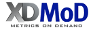 XDMoD Data Analytics Framework v1.0.1